In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats

plt.style.use('fivethirtyeight')

In [2]:
np.random.seed(5)
num = 10000
nbins = 499
multiplicity = np.int64(np.abs(np.round(np.random.normal(5, 1, num))))

mpion = 0.140 # rest mass of pion in GeV/c^2

pTrange = np.linspace(0.2, 5, nbins)
pTCDF = np.exp(-0.2*pTrange)
pTCDF = pTCDF / np.sum(pTCDF)

l_minv = []
l_E = []
l_px = []
l_py = []
l_pz = []

for i in range(num):
    pT = np.random.choice(pTrange, multiplicity[i], p = pTCDF)

    eta = np.random.normal(0, 2, multiplicity[i])
    theta = 2 * np.arctan(np.exp(-1*eta))
    phi = np.random.uniform(0, 2*np.pi, multiplicity[i])

    pTmag = np.abs(pT/np.sin(theta))
    pTx = pTmag * np.sin(theta) * np.cos(phi)
    pTy = pTmag * np.sin(theta) * np.sin(phi)
    pTz = pTmag * np.cos(theta)

    gamma = np.sqrt(1 + pTmag**2 / mpion**2)

    v_beta = np.array([pTx, pTy, pTz]) / (gamma * mpion)
    beta = np.sqrt(np.sum(v_beta**2, axis=0))

    p1 = mpion/2

    costhetarest = np.random.uniform(-1, 1, multiplicity[i])
    sinthetarest = np.sqrt(1 - costhetarest**2)
    phirest = np.random.uniform(0, 2*np.pi, multiplicity[i])

    Erestgamma1 = p1
    Erestgamma2 = p1
    pxrestgamma1 = p1 * sinthetarest * np.cos(phirest)
    pxrestgamma2 = -p1 * sinthetarest * np.cos(phirest)
    pyrestgamma1 = p1 * sinthetarest * np.sin(phirest)
    pyrestgamma2 = -p1 * sinthetarest * np.sin(phirest)
    pzrestgamma1 = p1 * costhetarest
    pzrestgamma2 = -p1 * costhetarest

    pgamma1 = np.array([
        gamma*Erestgamma1 + pTx/mpion * pxrestgamma1 + pTy/mpion * pyrestgamma1 + pTz/mpion * pzrestgamma1,
        pTx/mpion * Erestgamma1 + (1 + (gamma-1)*v_beta[0]*v_beta[0]/beta**2)*pxrestgamma1 + ((gamma-1)*v_beta[0]*v_beta[1]/beta**2)\
            *pyrestgamma1 + ((gamma-1)*v_beta[0]*v_beta[2]/beta**2)*pzrestgamma1,
        pTy/mpion * Erestgamma1 + ((gamma-1)*v_beta[1]*v_beta[0]/beta**2)*pxrestgamma1 + (1 + (gamma-1)*v_beta[1]*v_beta[1]/beta**2)\
            *pyrestgamma1 + ((gamma-1)*v_beta[1]*v_beta[2]/beta**2)*pzrestgamma1,
        pTz/mpion * Erestgamma1 + ((gamma-1)*v_beta[2]*v_beta[0]/beta**2)*pxrestgamma1 + ((gamma-1)*v_beta[2]*v_beta[1]/beta**2)\
            *pyrestgamma1 + (1 + (gamma-1)*v_beta[2]*v_beta[2]/beta**2)*pzrestgamma1
    ])

    pgamma2 = np.array([
        gamma*Erestgamma2 + pTx/mpion * pxrestgamma2 + pTy/mpion * pyrestgamma2 + pTz/mpion * pzrestgamma2,
        pTx/mpion * Erestgamma2 + (1 + (gamma-1)*v_beta[0]*v_beta[0]/beta**2)*pxrestgamma2 + ((gamma-1)*v_beta[0]*v_beta[1]/beta**2)\
            *pyrestgamma2 + ((gamma-1)*v_beta[0]*v_beta[2]/beta**2)*pzrestgamma2,
        pTy/mpion * Erestgamma2 + ((gamma-1)*v_beta[1]*v_beta[0]/beta**2)*pxrestgamma2 + (1 + (gamma-1)*v_beta[1]*v_beta[1]/beta**2)\
            *pyrestgamma2 + ((gamma-1)*v_beta[1]*v_beta[2]/beta**2)*pzrestgamma2,
        pTz/mpion * Erestgamma2 + ((gamma-1)*v_beta[2]*v_beta[0]/beta**2)*pxrestgamma2 + ((gamma-1)*v_beta[2]*v_beta[1]/beta**2)\
            *pyrestgamma2 + (1 + (gamma-1)*v_beta[2]*v_beta[2]/beta**2)*pzrestgamma2
    ])

    Eprimegamma1 = np.random.normal(pgamma1[0], 0.05 * pgamma1[0])
    Eprimegamma2 = np.random.normal(pgamma2[0], 0.05 * pgamma2[0])

    pprimegamma1 = np.zeros(np.shape(pgamma1))
    pprimegamma2 = np.zeros(np.shape(pgamma2))

    pprimegamma1[0] = Eprimegamma1
    pprimegamma2[0] = Eprimegamma2
    pprimegamma1[1:] = pgamma1[1:] * Eprimegamma1 / pgamma1[0]
    pprimegamma2[1:] = pgamma2[1:] * Eprimegamma2 / pgamma2[0]

    E_pairwise = np.stack(np.meshgrid(Eprimegamma1, Eprimegamma2), -1).reshape(-1,2)
    px_pairwise = np.stack(np.meshgrid(pprimegamma1[1], pprimegamma2[1]), -1).reshape(-1,2)
    py_pairwise = np.stack(np.meshgrid(pprimegamma1[2], pprimegamma2[2]), -1).reshape(-1,2)
    pz_pairwise = np.stack(np.meshgrid(pprimegamma1[3], pprimegamma2[3]), -1).reshape(-1,2)

    minv = np.zeros(np.size(E_pairwise)//2)
    for j in range(np.size(E_pairwise)//2):
        minv[j] = np.sqrt(np.sum(E_pairwise[j])**2 - np.sum(px_pairwise[j])**2 - np.sum(py_pairwise[j])**2 - np.sum(pz_pairwise[j])**2)
    
    l_minv.append(minv.tolist())
    l_E.append(Eprimegamma1.tolist())
    l_E.append(Eprimegamma2.tolist())
    l_px.append(pprimegamma1[1].tolist())
    l_px.append(pprimegamma2[1].tolist())
    l_py.append(pprimegamma1[2].tolist())
    l_py.append(pprimegamma2[2].tolist())
    l_pz.append(pprimegamma1[3].tolist())
    l_pz.append(pprimegamma2[3].tolist())


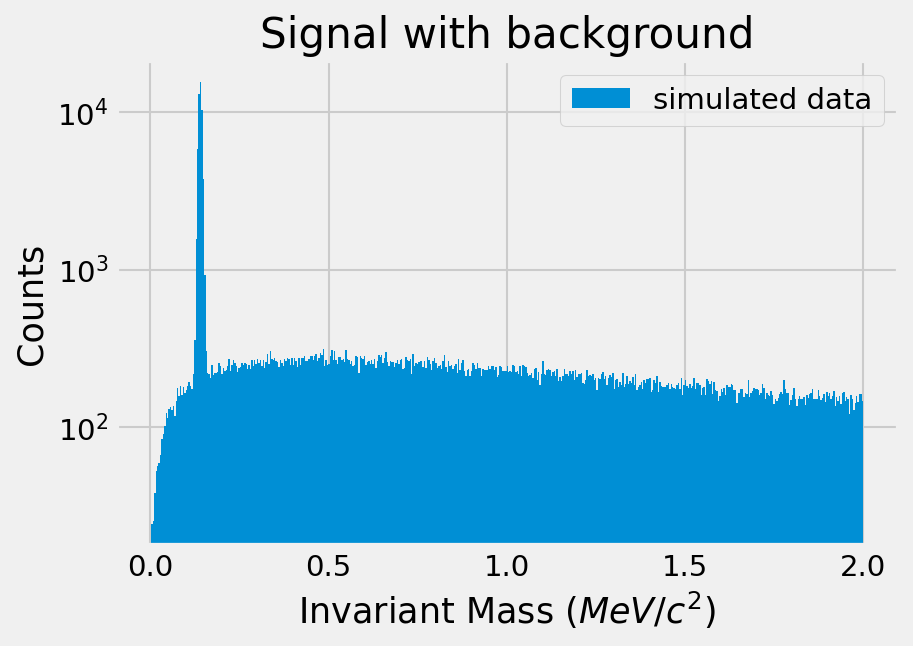

In [3]:
flat_minv = np.array([item for sublist in l_minv for item in sublist])
len(flat_minv)

plt.figure(dpi=150)
counts, bins, _ = plt.hist(flat_minv[flat_minv<2], nbins, label='simulated data')
plt.xlabel('Invariant Mass ($MeV/c^2$)')
plt.ylabel('Counts')
plt.yscale('log')
plt.title('Signal with background')
plt.legend()
plt.savefig('1.png', bbox_inches='tight')
plt.show()

In [4]:
flat_E = np.array([item for sublist in l_E for item in sublist])
flat_px = np.array([item for sublist in l_px for item in sublist])
flat_py = np.array([item for sublist in l_py for item in sublist])
flat_pz = np.array([item for sublist in l_pz for item in sublist])

In [5]:
np.random.seed(8)
r1 = np.random.randint(len(flat_E), size=len(flat_minv))
r2 = np.random.randint(len(flat_E), size=len(flat_minv))

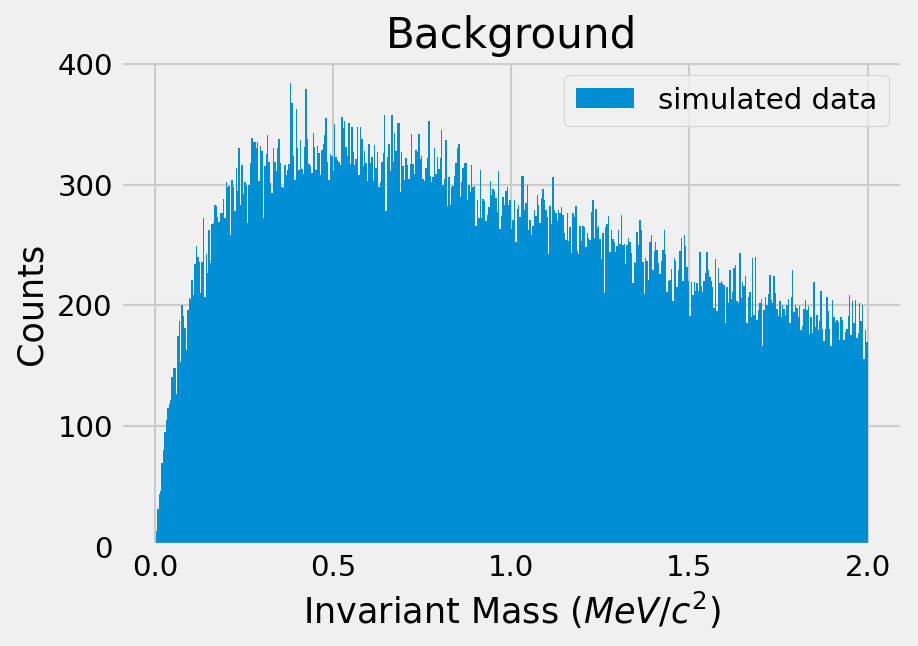

In [6]:
minv_bg = np.sqrt((flat_E[r1]+flat_E[r2])**2 - (flat_px[r1]+flat_px[r2])**2 - (flat_py[r1]+flat_py[r2])**2 - (flat_pz[r1]+flat_pz[r2])**2)
plt.figure(dpi=150)
counts2, bins2, _ = plt.hist(minv_bg[minv_bg<2], nbins, label='simulated data')
plt.xlabel('Invariant Mass ($MeV/c^2$)')
plt.ylabel('Counts')
plt.title('Background')
plt.legend()
plt.savefig('2.png', bbox_inches='tight')
plt.show()

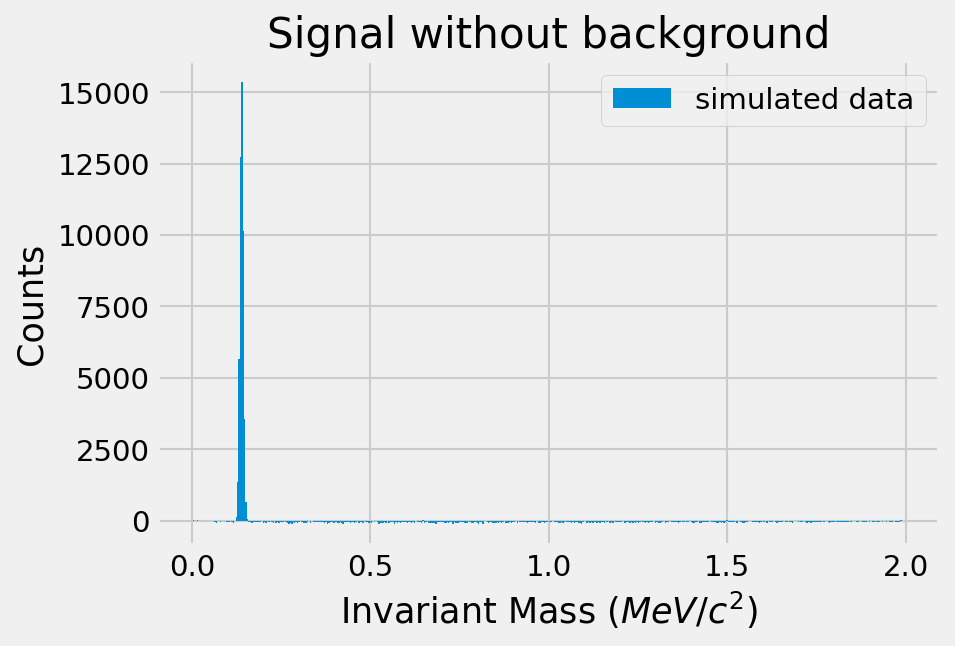

In [7]:
plt.figure(dpi=150)
counts3, bins3, _ = plt.hist(bins[:-1], nbins, weights=counts-counts2, label='simulated data')
plt.xlabel('Invariant Mass ($MeV/c^2$)')
plt.ylabel('Counts')
plt.title('Signal without background')
plt.legend()
plt.savefig('3.png', bbox_inches='tight')
plt.show()

In [8]:
def fit(x, A, sigma, x0):
    return A*np.exp(-(x-x0)**2/2/sigma**2)

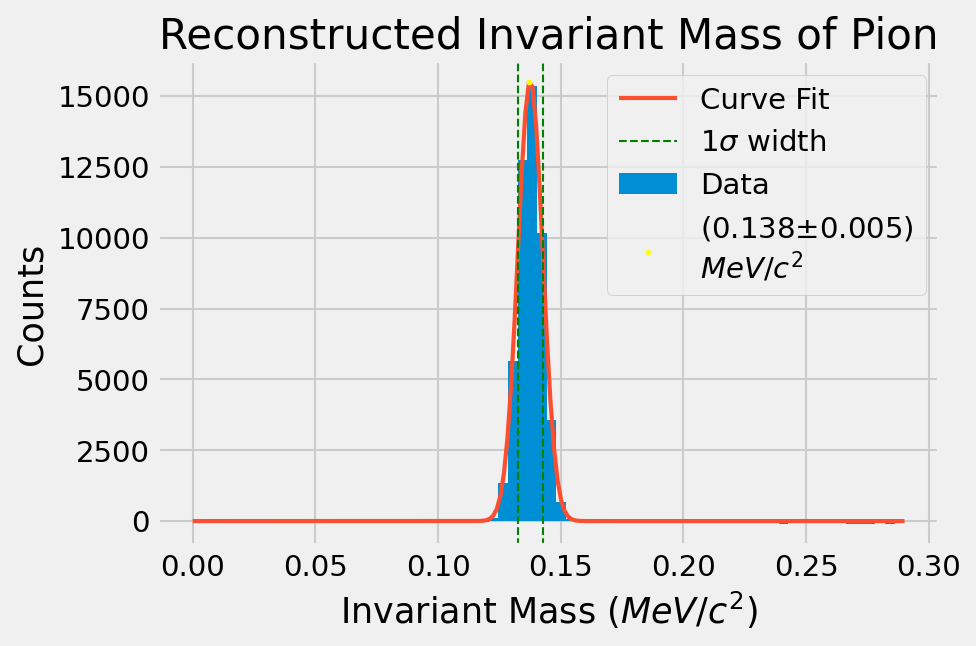

Invariant mass of neutral pion = 0.138+/-0.005 MeV/c^2
67% width of Gaussian = 0.010


In [9]:
idx = 72
popt, pcov = curve_fit(fit, bins3[:idx], counts3[:idx], p0=[np.max(counts3), 0.1, bins3[np.argmax(counts3)]])
plt.figure(dpi=150)
plt.hist(bins3[:idx], idx, weights=counts3[:idx], label='Data')
xt = np.linspace(0,bins3[idx],200)
yt = fit(xt, *popt)
plt.plot(xt, yt, label='Curve Fit', lw=2)
sigma = np.abs(popt[1])
plt.axvline(popt[2]-sigma, ls='--', lw=1, c='g', label='1$\sigma$ width')
plt.axvline(popt[2]+sigma, ls='--', lw=1, c='g')
perr = np.sqrt(np.diag(pcov))
plt.scatter(xt[np.argmax(yt)],np.max(yt), c='yellow', s=5, label=f'({popt[2]:.3f}$\pm${popt[1]:.3f})\n$MeV/c^2$', zorder=19)
plt.title('Reconstructed Invariant Mass of Pion')
plt.xlabel('Invariant Mass ($MeV/c^2$)')
plt.ylabel('Counts')
plt.legend()
plt.savefig('4.png', bbox_inches='tight')
plt.show()

print(f'Invariant mass of neutral pion = {popt[2]:.3f}+/-{popt[1]:.3f} MeV/c^2')
print(f'67% width of Gaussian = {2*popt[1]:.3f}')